In [152]:
import numpy as np
import pandas as pd
from collections import OrderedDict
import re
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.utils import shuffle
from wordcloud import WordCloud

In [62]:
corpus = ['Apple Orange Orange Apple','Apple Banana Apple Banana','Banana Apple Banana Banana Banana Apple',\
          'Banana Orange Banana Banana Orange Banana','Banana Apple Banana Banana Orange Banana']

In [63]:
''' Create a function to vectorize the counts of a list of sentences. Does not ignore case.'''
def myCountVec(corpus):
    bag = set()  # use a set to figure out how many unique words there are
    word_index = dict() # use a dict to store the column index of the word
    for line in corpus:
        for word in line.split():
            if word in bag:
                continue
            else:
                bag.add(word)
    list_of_words = sorted(list(bag)) # sort the list of words derived from set
    for index,word in enumerate(list_of_words):
        word_index[word] = index  # assign index to word
    vec_of_counts = np.zeros((len(corpus),len(word_index))) # create dummy matrix with all locations initilised to 0
    for row,line in enumerate(corpus):
        for word in line.split():
            col = word_index[word]
            vec_of_counts[row][col] += 1  # populate the matrix, increasing a word count when needed.
    return vec_of_counts

In [64]:
myCountVec(corpus)

array([[2., 0., 2.],
       [2., 2., 0.],
       [2., 4., 0.],
       [0., 4., 2.],
       [1., 4., 1.]])

In [86]:
df = pd.read_csv('MrTrumpSpeeches.csv', sep='~', encoding='latin1')
df['sentiment'] = np.where(df['like_count'] > df['dislike_count'], 1, 0)
df =shuffle(df)
df.head()

,id,playlist,upload_date,title,view_count,average_rating,like_count,dislike_count,subtitles,sentiment
495,4W9JjnFPAS4,Donald Trump Rally Speech Events Press Confere...,20161001,"Donald Trump Rally in Manheim, Pennsylvania",383.0,4.833333,23.0,1.0,we are going to make America great again ...,1
383,OXtUDIyshSw,President Donald Trump's First 100 Days | NBC ...,20170313,Donald Trump's First 50 Days: What The Preside...,7064.0,3.666667,48.0,24.0,Donald Trump has hit the 50 day mark of h...,1
400,RpjN4iEz9Oo,President Donald Trump's First 100 Days | NBC ...,20170404,Susan Rice: 'I Leaked Nothing To Nobody' About...,278754.0,3.869894,1897.0,747.0,and good day I'm Andrea Mitchell in Washi...,1
197,Sbe-lAWX7BQ,DONALD TRUMP SPEECHES & PRESS CONFERENCE,20170208,FULL: President Donald Trump Speech at Major C...,8806.0,4.523179,133.0,18.0,ladies and gentlemen the President of the...,1
474,15rCLS0Niec,Donald Trump Rally Speech Events Press Confere...,20160629,Governor LePage Introduces Donald Trump in Mai...,1064.0,4.714286,26.0,2.0,my great friend governor paul lepage of t...,1


In [87]:
# lets check some characteristics of the datframe
df.shape

(836, 10)

In [88]:
# ok so 836 rows by 10 columns. Lets check the numeric columns for issues
df.describe()

,upload_date,view_count,average_rating,like_count,dislike_count,sentiment
count,8.360000e+02,8.360000e+02,836.000000,836.000000,836.000000,836.000000
mean,2.016526e+07,2.478265e+04,4.345376,288.478469,56.348086,0.912679
std,4.783116e+03,6.020921e+04,0.702294,498.063763,188.722867,0.282473
min,2.016020e+07,7.100000e+01,1.347826,2.000000,0.000000,0.000000
25%,2.016081e+07,1.788000e+03,4.263935,29.000000,4.000000,1.000000
50%,2.016110e+07,8.775500e+03,4.589107,122.000000,19.000000,1.000000
75%,2.017031e+07,2.270900e+04,4.782065,358.250000,47.000000,1.000000
max,2.017080e+07,1.013054e+06,5.000000,6143.000000,3544.000000,1.000000


In [89]:
# ok so far so good. Lets check the non numeric columns
for col in ['id','playlist','title','subtitles']:
    print(df[col].describe())

count             836
unique            836
top       qi6UCC_L0WU
freq                1
Name: id, dtype: object
count                                                   836
unique                                                    5
top       Donald Trump Rally Speech Events Press Confere...
freq                                                    369
Name: playlist, dtype: object
count                                                   836
unique                                                  834
top       WATCH: President Donald Trump Press Conference...
freq                                                      2
Name: title, dtype: object
count                                                   836
unique                                                  836
top          my fellow Americans it's an exciting   time...
freq                                                      1
Name: subtitles, dtype: object


In [90]:
# so looks like we have all the data. Lets check for missing data and nans
df.isnull().any()

id                False
playlist          False
upload_date       False
title             False
view_count        False
average_rating    False
like_count        False
dislike_count     False
subtitles         False
sentiment         False
dtype: bool

In [91]:
# so there are some genral punctuation marks that should be removed since they dont add anything to the context.
# Some word are enclosed inside [] indicating environment and not really contributing to the sentiment anaylysis
def cleaningFunc(line):
    line = re.sub('[\/\+\-,:.\'\$*%\&]','',line) # remove puctuation marks etc.
    line = line.lower() # convert everthing to lowercase
    words = line.split() # split into words
    newwords = []
    for word in words:
        if "[" in word: # skip words enclosed in brackets
            continue
        word = word.strip(' ') # remove any trailing or leading spaces
        newwords.append(word)
    return " ".join(newwords) # return sentence with word seperated by a single space

In [100]:
df['subtitle_clean'] = df['subtitles'].apply(lambda x : cleaningFunc(x))
df.head()

,id,playlist,upload_date,title,view_count,average_rating,like_count,dislike_count,subtitles,sentiment,subtitle_clean
495,4W9JjnFPAS4,Donald Trump Rally Speech Events Press Confere...,20161001,"Donald Trump Rally in Manheim, Pennsylvania",383.0,4.833333,23.0,1.0,we are going to make America great again ...,1,we are going to make america great again we ar...
383,OXtUDIyshSw,President Donald Trump's First 100 Days | NBC ...,20170313,Donald Trump's First 50 Days: What The Preside...,7064.0,3.666667,48.0,24.0,Donald Trump has hit the 50 day mark of h...,1,donald trump has hit the 50 day mark of his pr...
400,RpjN4iEz9Oo,President Donald Trump's First 100 Days | NBC ...,20170404,Susan Rice: 'I Leaked Nothing To Nobody' About...,278754.0,3.869894,1897.0,747.0,and good day I'm Andrea Mitchell in Washi...,1,and good day im andrea mitchell in washington ...
197,Sbe-lAWX7BQ,DONALD TRUMP SPEECHES & PRESS CONFERENCE,20170208,FULL: President Donald Trump Speech at Major C...,8806.0,4.523179,133.0,18.0,ladies and gentlemen the President of the...,1,ladies and gentlemen the president of the unit...
474,15rCLS0Niec,Donald Trump Rally Speech Events Press Confere...,20160629,Governor LePage Introduces Donald Trump in Mai...,1064.0,4.714286,26.0,2.0,my great friend governor paul lepage of t...,1,my great friend governor paul lepage of the st...


For the classification tests I will be using F1 score because we are doing binary classification and this score incorporates
both false positives and false negatives in the metric.

In [144]:
cvecs = CountVectorizer(max_df=0.95,min_df=2,stop_words='english')
Xcv = cvecs.fit_transform(df['subtitle_clean'].values)
print("Count matrix shape :", Xcv.shape)
tfvecs = TfidfVectorizer(max_df=0.95,min_df=2,stop_words='english') 
Xtf = tfvecs.fit_transform(df['subtitle_clean'].values)
print("Tfidf matrix shape :", Xtf.shape)
# lets makes the 1 to 3 word ngram tfidf feature matrix
tfvecsngram = TfidfVectorizer(max_df=0.95,min_df=2,stop_words='english',ngram_range=(1,3))
Xtfng = tfvecs.fit_transform(df['subtitle_clean'].values)
print("Tfidf ngram matrix shape :", Xtfng.shape)

Count matrix shape : (836, 15207)
Tfidf matrix shape : (836, 15207)
Tfidf ngram matrix shape : (836, 15207)


F1 score for test Logistic regression model on word count is 95.23%
F1 score for test Logistic regression model on TFIDF is 96.29%
F1 score for test Logistic regression model on TFIDF + ngram is 96.29%
F1 score for test Support Vector Machine model on word count is 93.89%
F1 score for test Support Vector Machine model on TFIDF is 94.96%
F1 score for test Support Vector Machine model on TFIDF + ngram is 94.96%
Tests complete


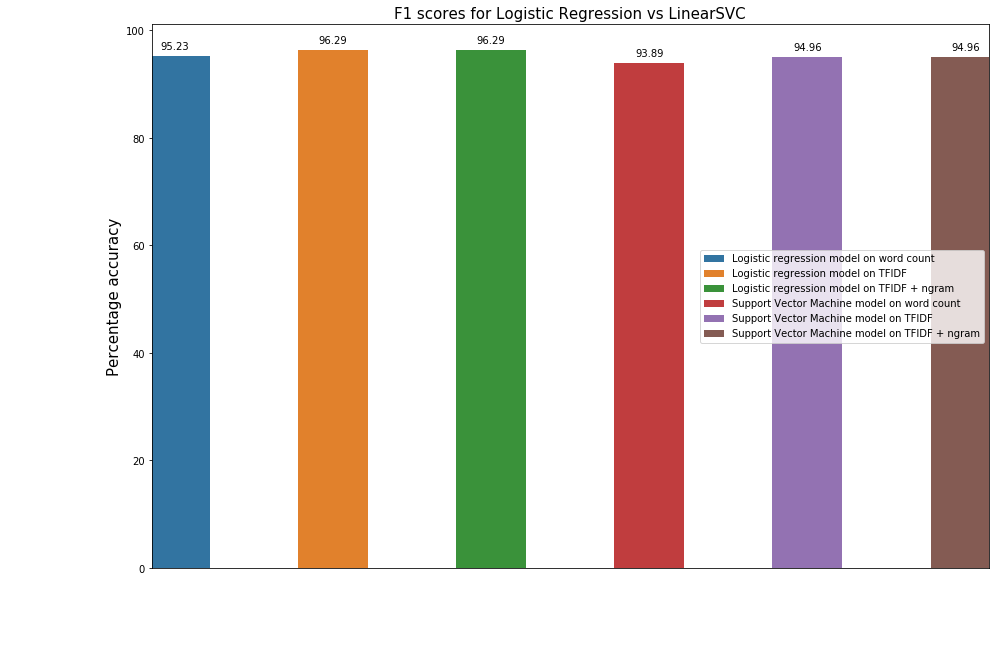

In [101]:
# lets run a loop for all the tests and store the f1 score in a list for plotting later
tests = {1:'Logistic regression model on word count',2:'Logistic regression model on TFIDF',\
         3:'Logistic regression model on TFIDF + ngram',4:'Support Vector Machine model on word count',\
         5:'Support Vector Machine model on TFIDF',6:'Support Vector Machine model on TFIDF + ngram'}
results = []
for index,dataset in enumerate([Xcv,Xtf,Xtfng]*2):
    X_train,X_test,y_train,y_test = train_test_split(dataset,df['sentiment'],test_size=0.2,random_state=0)
    if index < 3:
        logistic = LogisticRegression()
        logistic.fit(X_train,y_train)
        y_pred = logistic.predict(X_test)
        score = int(f1_score(y_test,y_pred) * 10000) / 100.0
        print("F1 score for test {} is {}%".format(tests[index+1],score))
        results.append((index+1,score))
    elif index < 6:
        support_vector = LinearSVC()
        support_vector.fit(X_train,y_train)
        y_pred = support_vector.predict(X_test)
        score = int(f1_score(y_test,y_pred) * 10000) / 100.0
        print("F1 score for test {} is {}%".format(tests[index+1],score))
        results.append((index+1,score))
    else:
        pass
print("Tests complete")
###########################################################################################
# lets plot the barplot of values
plotting_df = pd.DataFrame(list(tests.items()),columns=['index','Test'])
plotting_df['score'] = [x[1] for x in results]
fig,ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(15)
sns.barplot(x='index',y='score',hue='Test',data=plotting_df,ax=ax)
plt.xticks([])
plt.xlabel('') # remove xlabels
plt.ylabel('Percentage accuracy',fontsize=15)
plt.title("F1 scores for Logistic Regression vs LinearSVC",fontsize=15)
ax.legend(loc=5)
for bar in ax.patches:
    x = bar.get_x()
    width = bar.get_width()
    centre = x + width/2.
    bar.set_x(centre - 0.5/2.)
    bar.set_width(0.5)
    height = bar.get_height()
    ax.annotate("%.2f" % height, (x + width / 2., height),
             ha='center', va='center', rotation=0, xytext=(0, 10), textcoords='offset points')

## Topic Modeling (20 marks)
1. Using TFIDF and Count Vectorizer models imported for sklearn, perform topic modelling using the following topic modeling algorithms:
    1. NMF
    2. LDA
    3. SVD

2. When choosing the number of topics give a brief explanation of why that number was chosen.
3. Discuss based on the top 10 words each of the algorithms choose for each topic cluster what category the topics fall under.

In [148]:
documents = df['subtitle_clean']

tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english',max_features=1000)
tfidf = tfidf_vectorizer.fit_transform(documents)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english',max_features=1000)
tf = tf_vectorizer.fit_transform(documents)
tf_feature_names = tf_vectorizer.get_feature_names()

n_topics = 10
no_top_words = 10
no_top_documents = 4

def display_topics(H, W, feature_names, documents, no_top_words, no_top_documents):
    for topic_idx, topic in enumerate(H):
        print("Topic {}:".format(topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
#         print("") 
#         top_doc_indices = np.argsort( W[:,topic_idx] )[::-1][0:no_top_documents]
#         for doc_index in top_doc_indices:
#             print(documents[doc_index])
#             print("")

In [149]:
nmf_model = NMF(n_components=n_topics, random_state=0, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)
nmf_W = nmf_model.transform(tfidf)
nmf_H = nmf_model.components_

display_topics(nmf_H, nmf_W, tfidf_feature_names, documents, no_top_words, no_top_documents)

Topic 0:
know people going dont said like right want im theyre
Topic 1:
thanks exclusives highlights clicking digital channel checking button latest nbc
Topic 2:
thank great american america god want people nation today country
Topic 3:
hillary clinton country american jobs people going america new make
Topic 4:
donald trump america president know hes hillary united clinton states
Topic 5:
president house white trump intelligence information administration think presidents just
Topic 6:
peace israel minister united states prime nato president region terrorism
Topic 7:
going win jobs thank mexico folks trade wall theyre love
Topic 8:
judge justice court supreme law constitution senate judges laws states
Topic 9:
health obamacare care insurance plan premiums americans repeal tax american


In [150]:
lda_model = LatentDirichletAllocation(n_components=n_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)
lda_W = lda_model.transform(tf)
lda_H = lda_model.components_
display_topics(lda_H, lda_W, tfidf_feature_names, documents, no_top_words, no_top_documents)

Topic 0:
care health going veterans people obamacare thank country thats plan
Topic 1:
know people dont thank going think thats great want just
Topic 2:
american going jobs people country america thank great new make
Topic 3:
president trump think just house thanks know white going people
Topic 4:
gun people just rights regulation going amendment congress make second
Topic 5:
thank people president going know great country states united want
Topic 6:
going people country hillary clinton jobs dont know great right
Topic 7:
great thank going american navy military people world ship right
Topic 8:
going know people dont said like great right want im
Topic 9:
going people know country jobs dont great want thats hillary


In [151]:
lsi_model = TruncatedSVD(n_components=10, n_iter=12, random_state=42).fit(tf)
lsi_W = lsi_model.transform(tf)
lsi_H = lsi_model.components_
display_topics(lsi_H, lsi_W, tfidf_feature_names, documents, no_top_words, no_top_documents)

Topic 0:
going people know dont said great like right want im
Topic 1:
american country america jobs clinton hillary thank president united states
Topic 2:
going win jobs folks trade theyre mexico vote country wall
Topic 3:
hillary clinton people percent shes said jobs country dont money
Topic 4:
trump donald hillary president said clinton going think hes did
Topic 5:
right know america hes donald love vote folks gonna american
Topic 6:
trade china jobs united states president mexico new trump world
Topic 7:
know think going thats care theres yeah sure hillary mean
Topic 8:
american im hes new jobs donald trump york people energy
Topic 9:
thank said great hillary right thats clinton going okay virginia


## Visualization (10 marks)
Choose the clusters obtained from a topic model algorithm from above and plot a word cloud
1. for each of the clusters. For example, if the number of topics chosen was 10 and the topics were obtained from the SVD algorithm, 10 word clouds should be plotted.

In [ ]:
def print_cloud(data):
    wordcloud = WordCloud(
              background_color='white',
              max_words=200,
              max_font_size=40, 
              random_state=42
             ).generate(str(data))
